In [1]:
from genetic_program import FitnessFunction
from gp_artemis import ExperimentManager
%matplotlib inline
import pandas as pd

class WowFitnessFunction(FitnessFunction):
    _name = "ff_sowow"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent * evaluation.num_sells,

class BenchmarkDiffFitnessFunction(FitnessFunction):
    _name = "ff_benchmarkdiff"

    def compute(self, individual, evaluation, genetic_program):
        return evaluation.profit_percent - evaluation.benchmark_backtest.profit_percent,
    
    
    
experiment_json = {
    "training_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/04/01 00:00:00 UTC",
        "end_time": "2018/06/01 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "validation_data": {
        "transaction_currency": "OMG",
        "counter_currency": "BTC",
        "start_time": "2018/03/01 00:00:00 UTC",
        "end_time": "2018/03/31 00:00:00 UTC",
        "resample_period": 60,
        "source": 0
    },

    "fitness_function": "ff_v1",
    "grammar_version": "gv1",
    "num_generations": 3,

    "mating_probabilities": [
        0.4,
        0.5,
        0.6
    ],

    "mutation_probabilities": [
        0.7,
        0.8,
        0.9
    ],

    "population_sizes": [
        500
    ]
}

e = ExperimentManager(experiment_json, read_from_file=False)
e.run_experiments(display_results=False)


INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.8;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.4;mutationprob_0.9;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_TAprovider;grammar_gv1;fitness_ff_v1;matingprob_0.5;mutationprob_0.7;populationsize_500;generations_3 already has completed records, skipping...
INFO:root:>>> Variant run_evolution.data_OMG-BTC-1522540800.0-1527811200.0;provider_

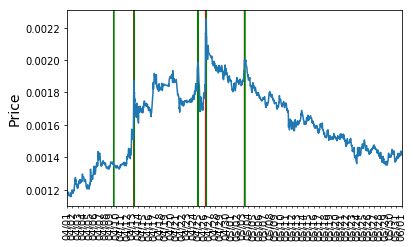

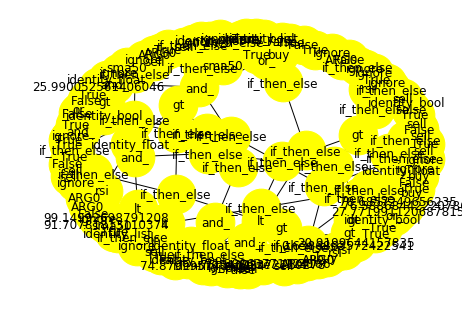

In [2]:
performance_df = e.analyze_and_find_best()

In [8]:
import pandas as pd
pd.set_option('display.max_columns', 500)
performance_df

,abc_negative_cache_version,alpha,benchmark_profit_percent,benchmark_profit_percent_usdt,beta,buy_currency,cash,counter_currency,crypto,current_price,current_timestamp,end_cash,end_crypto,end_crypto_currency,end_price,end_time,end_value,end_value_usdt,evaluate_profit_on_last_order,evaluation,experiment_id,hof_ranking,individual,max_buy_sell_pair_gain,max_buy_sell_pair_loss,max_buy_sell_pair_return,max_drawdown,max_drawdown_duration,mean_buy_sell_pair_gain,mean_buy_sell_pair_loss,mean_buy_sell_pair_return,min_buy_sell_pair_gain,min_buy_sell_pair_loss,min_buy_sell_pair_return,num_buy_sell_pairs,num_buys,num_gains,num_losses,num_orders,num_profitable_trades,num_sells,num_trades,num_unprofitable_trades,percent_profitable_trades,profit,profit_percent,profit_percent_usdt,profit_usdt,resample_period,sharpe_ratio,slippage,source,start_cash,start_crypto,start_time,start_value,start_value_usdt,std_buy_sell_pair_gain,std_buy_sell_pair_loss,std_buy_sell_pair_return,time_delay,transaction_cost_percent,transaction_currency,verbose
64,51,0.001350,14.261649,19.364172,0.870541,OMG,0.000000,BTC,800507.153796,0.001415,1.527811e+09,0.000000,800507.153796,OMG,0.001415,1.527811e+09,1132.541511,8.470302e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,4,"[<deap.gp.Primitive object at 0x11235fc78>, <d...",0.357875,-0.076098,0.357875,-0.372555,2847060.0,0.154426,-0.076098,0.108321,0.042410,-0.076098,-0.076098,5,6,4,1,11,4,5,11,1,0.800000,132.541511,13.254151,22.403215,1.550302e+06,60,0.210297,0,0,1000,0,1.522541e+09,1000,6920000.0,0.120566,0.000000,0.141885,0,0.0025,OMG,False
29,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,9,"[<deap.gp.Primitive object at 0x10e787c28>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09,1000,6920000.0,0.082494,0.000000,0.093409,0,0.0025,OMG,False
20,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,0,"[<deap.gp.Primitive object at 0x10e787c28>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09,1000,6920000.0,0.082494,0.000000,0.093409,0,0.0025,OMG,False
72,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,2,"[<deap.gp.Primitive object at 0x1135a7868>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09,1000,6920000.0,0.082494,0.000000,0.093409,0,0.0025,OMG,False
28,51,-0.001391,14.261649,19.364172,0.855932,OMG,0.000000,BTC,786943.912562,0.001415,1.527811e+09,0.000000,786943.912562,OMG,0.001415,1.527811e+09,1113.352509,8.326788e+06,True,<backtester_ticks.TickDrivenBacktester object ...,run_evolution.data_OMG-BTC-1522540800.0-152781...,8,"[<deap.gp.Primitive object at 0x10e787c28>, <d...",0.271626,-0.076098,0.271626,-0.365863,2854800.0,0.083062,-0.076098,0.063167,0.008498,-0.076098,-0.076098,8,9,7,1,17,7,8,17,1,0.875000,113.352509,11.335251,20.329299,1.406788e+06,60,0.193838,0,0,1000,0,1.522541e+09

In [3]:
best = performance_df.iloc[0]['individual']

In [9]:
str(best)

'if_then_else(gt(identity_float(rsi(identity_list(ARG0))), sma50(identity_list(identity_list(ARG0)))), if_then_else(and_(gt(sma50(ARG0), identity_float(25.990052561406046)), lt(sma50(ARG0), identity_float(71.30063771924186))), if_then_else(and_(or_(False, True), and_(False, False)), if_then_else(and_(True, True), if_then_else(True, sell, ignore), if_then_else(True, ignore, sell)), if_then_else(identity_bool(True), if_then_else(True, ignore, sell), if_then_else(True, buy, sell))), if_then_else(gt(rsi(ARG0), identity_float(78.6857249656235)), if_then_else(lt(91.70781813110374, 99.14992698791208), if_then_else(False, sell, sell), if_then_else(False, buy, ignore)), if_then_else(lt(74.87999574040454, 76.54302372110278), if_then_else(True, buy, ignore), if_then_else(False, sell, buy)))), if_then_else(and_(and_(or_(False, True), gt(76.58868442220786, 27.771991120687815)), identity_bool(identity_bool(False))), if_then_else(gt(rsi(ARG0), rsi(ARG0)), if_then_else(or_(True, True), if_then_else(Fa

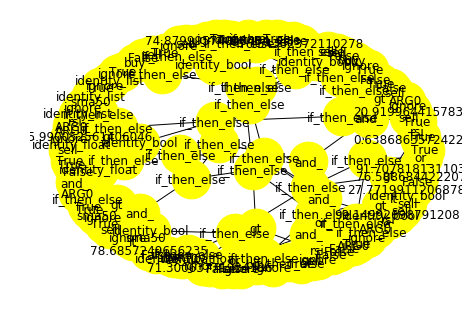

In [10]:
from chart_plotter import draw_tree
draw_tree(best)

In [11]:
print(performance_df.iloc[0].evaluation.get_report())

--

* Order execution log *

Start balance: cash = 1000 BTC, crypto = 0 
Start time: 2018-04-01 00:00:00
--
--
2018-04-09 13:00:00  	 OrderType.BUY    	 cash_balance ->      -1000.00 BTC 	 currency_balance -> 740627.993139 OMG 	 (1 OMG = 0.00134683 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-09 13:00:00 rsi_value=None
2018-04-13 04:00:00  	 OrderType.SELL   	 cash_balance ->       1354.48 BTC 	 currency_balance -> -740627.993139 OMG 	 (1 OMG = 0.00183341 BTC ), slippage = 0.00
   signal: genetic_down strength=3 trend=-1 horizon=None timestamp=2018-04-13 04:00:00 rsi_value=None
2018-04-13 06:00:00  	 OrderType.BUY    	 cash_balance ->      -1354.48 BTC 	 currency_balance -> 758977.547833 OMG 	 (1 OMG = 0.00178015 BTC ), slippage = 0.00
   signal: genetic_up strength=3 trend=1 horizon=None timestamp=2018-04-13 06:00:00 rsi_value=None
2018-04-24 20:00:00  	 OrderType.SELL   	 cash_balance ->       1502.79 BTC 	 currency_balance -> -758977

In [12]:
print(performance_df.iloc[0].evaluation.benchmark_backtest.get_report())

--

* Order execution log *

Start balance: cash = 1000 BTC, crypto = 0 
Start time: 2018-04-03 03:00:00
--
--
2018-04-03 03:00:00  	 OrderType.BUY    	 cash_balance ->      -1000.00 BTC 	 currency_balance -> 809652.519054 OMG 	 (1 OMG = 0.00123201 BTC ), slippage = 0.00
   signal: None
2018-06-01 00:00:00  	 OrderType.SELL   	 cash_balance ->       1142.62 BTC 	 currency_balance -> -809652.519054 OMG 	 (1 OMG = 0.00141478 BTC ), slippage = 0.00
   signal: None
End time: 2018-06-01 00:00:00

Summary
--
Number of trades: 2
End cash: 1142.62 BTC
End crypto: 0.000000 OMG
End price: 0.00141478
Total value invested: 1000 BTC
Total value after investment: 1142.62 BTC (+14.26%)
Profit: 142.62 BTC
Total value invested: 7165034.75 USDT (conversion on 2018-04-03 03:00:00)
Total value after investment: 8552484.43 USDT (+19.36%) (conversion on 2018-06-01 00:00:00)
Profit: 1387449.69 USDT

Additional stats:
  Max drawdown: -0.4012452438602555
  Max drawdown duration: 2847060.0
  Sharpe ratio: 0.216

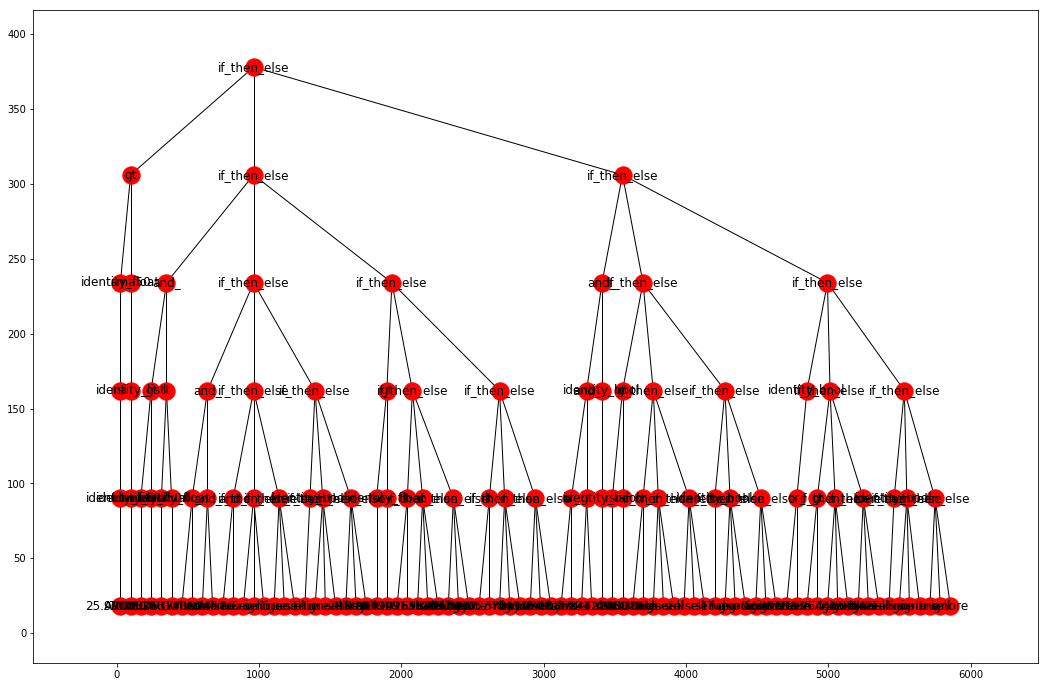

In [13]:
from chart_plotter import networkx_graph
networkx_graph(best)

In [14]:
from chart_plotter import write_graph_to_json
write_graph_to_json(performance_df.iloc[0]['individual'], "graph.json")


In [15]:
from IPython.core.display import HTML, Javascript
from chart_plotter import create_jupyter_dna_container, show_doge_dna
HTML(create_jupyter_dna_container("test-container"))

In [16]:
js = show_doge_dna("test-container","graph.json")
Javascript(js)

<IPython.core.display.Javascript object>